In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 8

# UWavy Navigation - Solution

1. Overview
2. Inertial Navigation
3. Image Recognition
4. Synthesis
5. Conclusion


## Overview (TODO)



## Inertial Navigation

### Generating a "True" Path
[TODO: Animation]

In [ ]:
def wide_uturn(leg=10):
    ones = np.ones((leg,1));
    zeros = np.zeros((leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros, ones))
    leg3 = np.hstack((-ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

def s_turn(short_leg=5):
    ones = np.ones((short_leg,1));
    zeros = np.zeros((short_leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros*2, -ones*2))
    leg3 = np.hstack((ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

# Set out a path, starting at START_POS and following updates along DELTAS_TRUE
start_pos = np.array([[1500,850]])
deltas_true = (np.vstack((np.vstack([s_turn(1) for _ in range(3)]), wide_uturn(3))) * 25).astype(np.float64)
path_true = np.cumsum(np.vstack((start_pos, deltas_true)), axis=0)

## TODO Plot path_true
ani = FlightAnimator()
ani.add_path(path_true, label="True Path")
ani.start();

### Introducing Systematic and Random Error
[TODO: Animation]

In [ ]:
# Simulate some input from the onboard sensors and camera
deltas_inert = (deltas_true - np.array([3, -1])).astype(np.float64) # Add systematically biased error 
# TODO add random error
ani = FlightAnimator()
ani.add_path(path_sim, label="Simulated Path")
ani.start();

## Image Recognition
As can be seen abocve, inertial navigation on its own is not very impressive, but combining it images taken from a drone's onboard camera can yield excellent results. This section explains how the image recognition part of the software works through ________ and demo ___ idk


A drone uses it's onboard camera to take an image of the ground. This image is later compared to images from the database to estimate the drone's location.

### Simulating the image database
This simulation is the most basic MVP as it uses a single image for the database. Our reference image—seen below—is a map of New York City comprising all five boroughs with a pixel density of [blah blah blah]. Future iterations will use multiple such images stiched together, but this should work fairly well for navigation about a single city such as New York. 

In [59]:
from PIL import Image
ref_img = np.array(Image.open('manhattan.jpg'))
RADIUS = 180

def take_picture(drone_position):
    x_center = drone_position[0]
    y_center = drone_position[1]
    return ref_img[x_center - RADIUS : x_center + RADIUS, y_center - RADIUS : y_center + RADIUS]

def plot_ref_img(ax=None, drone_pos=None, crop_height=1):
    if ax is None:
        plt.title("Reference Image")
        ax = plt
    else:
        ax.set_title("Reference Image")
    ax.imshow(ref_img.take(range(int(ref_img.shape[0] * crop_height)), axis=0), alpha = 1 if drone_pos is None else .75 );
    ax.axis('off');
    
    if drone_pos is not None:
        from matplotlib.patches import Rectangle;
        N = 150;
        pos = np.flip(drone_pos - RADIUS)
        ax.add_patch(Rectangle(pos, RADIUS * 2, RADIUS * 2, color="dodgerblue", fill=False, linewidth=3, label="Camera View"));
        plt.legend()
        
def plot_line_error(drone_position, ax):
    # Plot a horizontal line representing the positions searched
    ax.axhline(drone_position[0])
    
    # Take successive slices of REF_IMG along a vertical axis that runs through (x,y) and plot the error 
    test_img = take_picture(drone_position)
    errs = []
    rng = range(0, ref_img.shape[1], 5)
    for i, x in enumerate(rng):
        ref_slice = ref_img[x  : x + 2 * RADIUS, drone_position[0] - RADIUS : drone_position[0] + RADIUS]
        err = np.sum(np.square(test_img - ref_slice)) / ref_img.size
        errs.append(err)
    errs = np.array(errs)
    ax.twinx().plot(rng, errs, 'r', linewidth=3, label="Mean Squared Error");

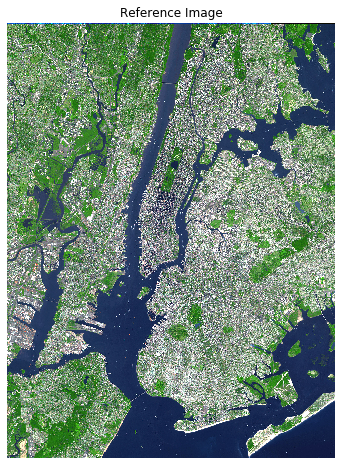

In [24]:
plot_ref_img();

### Simulating the onboard camera
In the real world, a drone will use its onboard camera to capture an image of the ground directly beneath it. The area of terrain captured will depend on the focal length of the camera, which is known beforehand, and the altitude of the drone, which can be measured in real time. Thus, the image captured will be a rectangle — we chose to model it as a square for simplicity — with the drone's actual location at the center. 

This definition allows a straightforward simulation of the drone's onboard camera. "Taking a picture" in the simulation just means taking a slice of the reference image of a given size with the drone's true position — which is known exactly in the simulation — at the center. This of course does not account for changes in lighting, shadows or other movable objects, but we found we achieved promising results that validated our MVP with just this simple model. 

```python
def take_picture(img, drone_position, radius):
    x_center = drone_position[TODO]
    y_center = drone_position[TODO]
    return img[x_center - radius : x_center + radius, y_center - radius : y_center + radius]
```

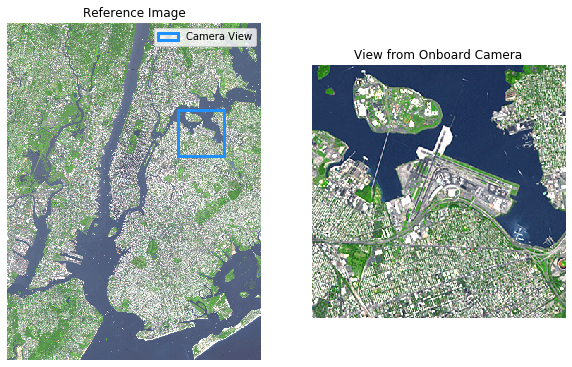

In [10]:
pos = np.array((850,1500))

ax = plt.subplot(1,2,1)
plot_ref_img(ax, pos)

img = take_picture(pos)

plt.subplot(1,2,2)
plt.imshow(img)
plt.title("View from Onboard Camera")
plt.axis('off');

### Comparing the captured image with the database
To determine if the drone is in a particular location, we compare the image taken by the drone's camera with identically sized slices from the reference image. When the two images match, we know that the drone must be at the exact center of the matching slice. We define a straightforward algorithm for matching image slices: compare each pixel value for value and take the mean squared error, i.e.
```python
error = np.sum(np.square(test_slice - ref_slice)) / num_pixels
```
where test_slice is the image captured from the camera and ref_slice is a slice from the database.



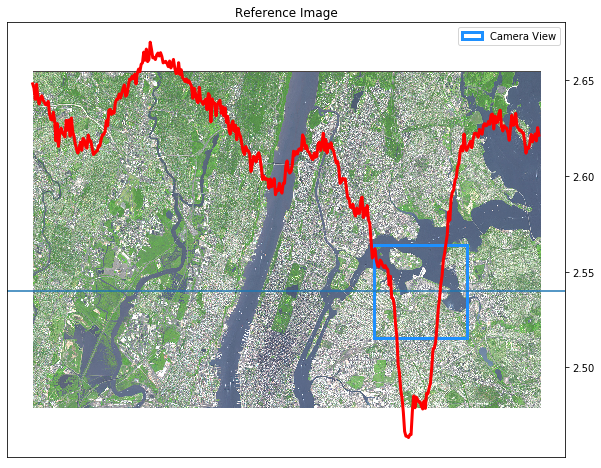

In [60]:
ax = plt.subplot(1,1,1)
plot_ref_img(ax, pos, crop_height=.5)
plot_line_error(pos, ax)
# TODO deal with lengend

### Searching the database for the captured image

In [ ]:
# TODO: heatmaps, etc



## Synthesis

### Informing the Search Algorithm
1. Starting Point = from intertial nav
1. Sprial Pattern
1. Search Confidence
### Combining Intertial + Image Recognition
1. Putting the pieces together
[Animation with both inertial + img rec]

In [ ]:
ani = FlightAnimation()
ani.add_target_start(path_true[0])
ani.add_target_end(path_true[-1])
ani.add_path(path_sim)
ani.add_path(path_sim_plus)
ani.start();

## Conclusion
[TODO: Make some over-generalizing statements]
### Future Steps
1. Increasing search radius dynamically